In [1]:
#One Class Vector Machine Anomaly Detection

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

df = pd.read_csv('filtered_data.csv')
#df = df[['speed', 'flow', 'occ']]
df.head(10)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   day       200000 non-null  object 
 1   interval  200000 non-null  int64  
 2   detid     200000 non-null  object 
 3   flow      200000 non-null  float64
 4   occ       200000 non-null  float64
 5   error     158545 non-null  float64
 6   city      200000 non-null  object 
 7   speed     200000 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 12.2+ MB


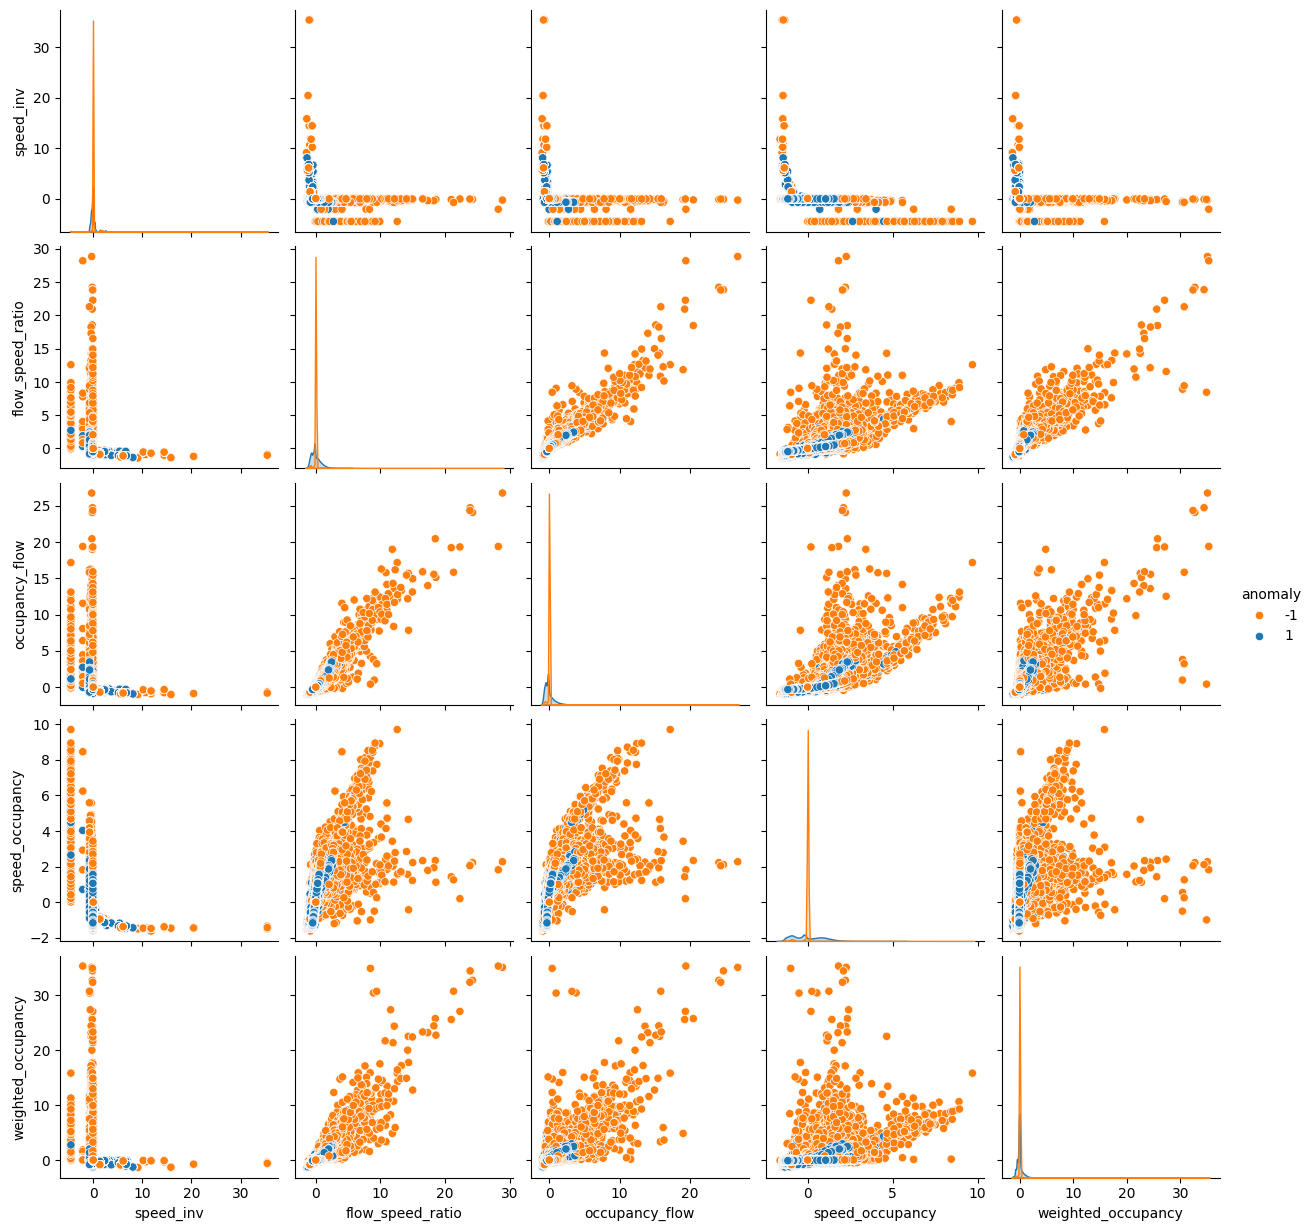

In [2]:
# OCSVM

from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

from numpy import quantile, where, random
import numpy as np

import seaborn as sns

det_ids = df['detid'].unique()
combined_results = pd.DataFrame()
sensor_models = {}

scaler = StandardScaler()

for det_id in det_ids:
    sensor_data = df[df['detid'] == det_id].copy()
    
    # Zero Speeds
    sensor_data.loc[sensor_data['speed'] == 0, 'speed'] = np.finfo(float).eps

    # Feature Engineering
    sensor_data['speed_inv'] = 1 / sensor_data['speed']
    sensor_data['flow_speed_ratio'] = sensor_data['flow'] / sensor_data['speed']
    sensor_data['occupancy_flow'] = sensor_data['occ'] * sensor_data['flow']
    sensor_data['speed_occupancy'] = sensor_data['speed'] * sensor_data['occ']
    sensor_data['weighted_occupancy'] = sensor_data['occ'] * sensor_data['speed_inv']
    
    # Scale features
    features_to_scale = ['speed_inv', 'flow_speed_ratio', 'occupancy_flow', 'speed_occupancy', 'weighted_occupancy']
    sensor_data[features_to_scale] = scaler.fit_transform(sensor_data[features_to_scale])
    
    # Train model
    svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
    svm.fit(sensor_data[features_to_scale])

    sensor_models[det_id] = svm

    # Anomaly score and label
    sensor_data['anomaly_score'] = svm.decision_function(sensor_data[features_to_scale])
    sensor_data['anomaly'] = svm.predict(sensor_data[features_to_scale])

    # Combine results into one dataframe
    combined_results = pd.concat([combined_results, sensor_data], ignore_index=True)

# Display combined results
palette = ['#ff7f0e', '#1f77b4']
sns.pairplot(combined_results, vars=['speed_inv', 'flow_speed_ratio', 'occupancy_flow', 'speed_occupancy', 'weighted_occupancy'], hue='anomaly', palette=palette)

plt.show()


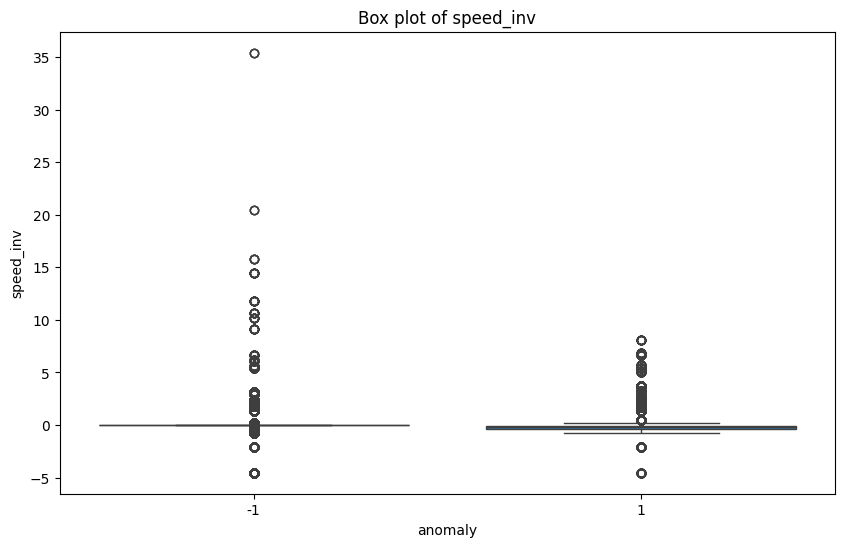

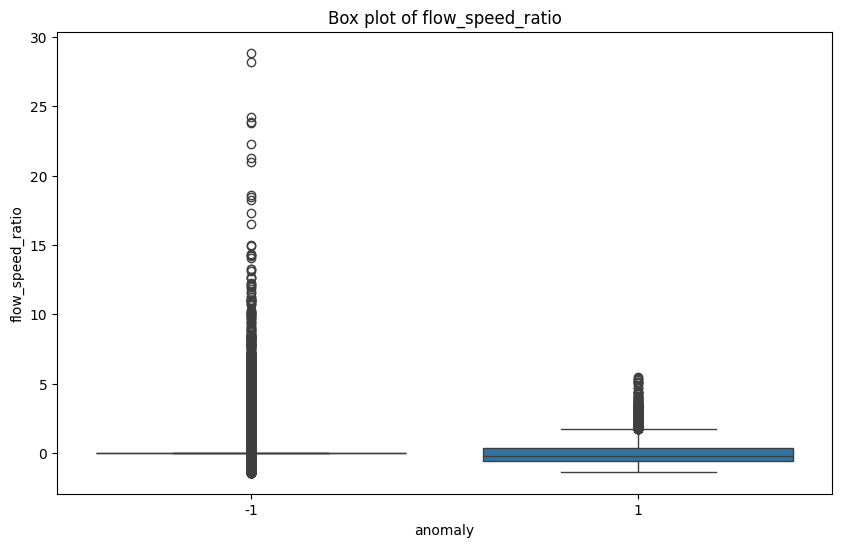

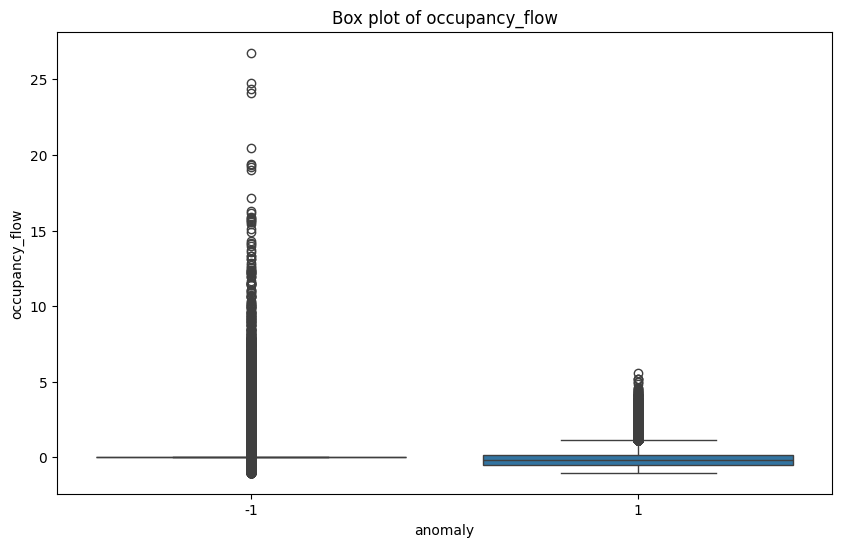

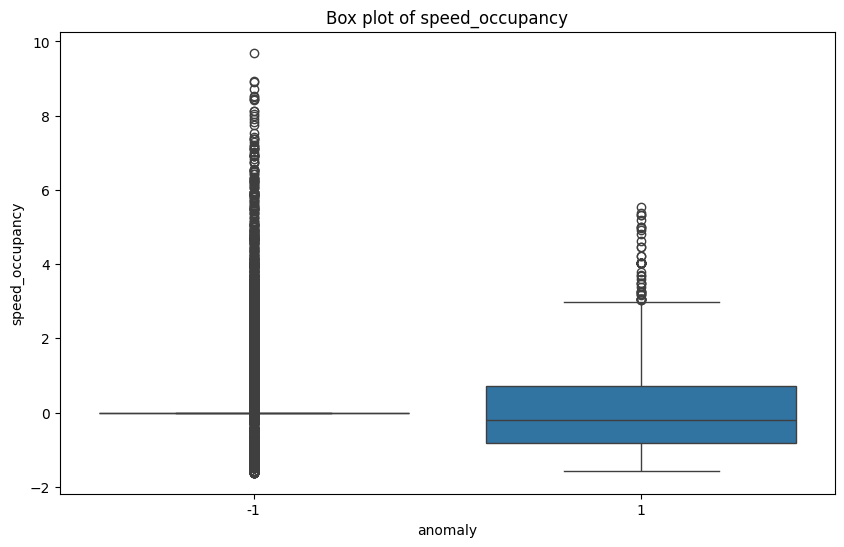

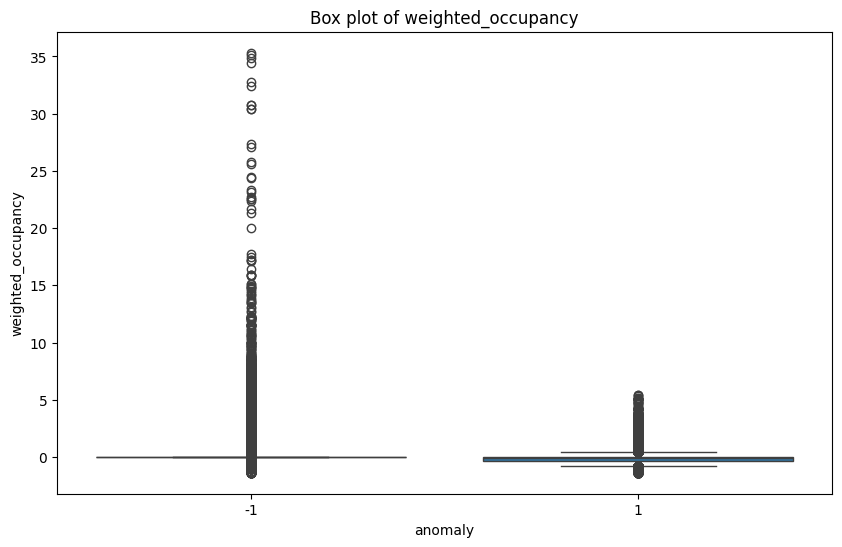

In [3]:
# Display Box Plot

features_to_plot = ['speed_inv', 'flow_speed_ratio', 'occupancy_flow', 'speed_occupancy', 'weighted_occupancy']
for feature in features_to_plot:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='anomaly', y=feature, data=combined_results)
    plt.title(f'Box plot of {feature}')
    plt.show()

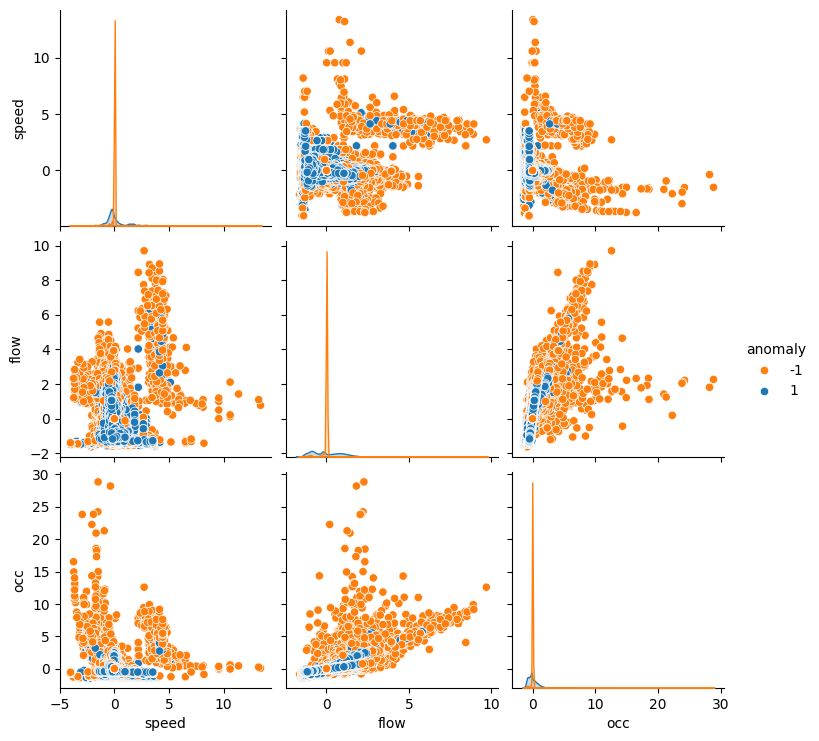

In [4]:
# OCSVM without Feature Engineering

det_ids = df['detid'].unique()
combined_results = pd.DataFrame()
sensor_models = {}

for det_id in det_ids:
    sensor_data = df[df['detid'] == det_id].copy()
    
    # Scale features
    features_to_scale = ['speed', 'flow', 'occ']
    scaler = StandardScaler()
    sensor_data[features_to_scale] = scaler.fit_transform(sensor_data[features_to_scale])
    
    # Train model
    svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
    svm.fit(sensor_data[features_to_scale])

    sensor_models[det_id] = svm

    # Anomaly score and label
    sensor_data['anomaly_score'] = svm.decision_function(sensor_data[features_to_scale])
    sensor_data['anomaly'] = svm.predict(sensor_data[features_to_scale])

    # Combine results into one dataframe
    combined_results = pd.concat([combined_results, sensor_data], ignore_index=True)

# Display combined results
palette = ['#ff7f0e', '#1f77b4']
sns.pairplot(combined_results, vars=['speed', 'flow', 'occ'], hue='anomaly', palette=palette)

plt.show()